# Linear Regression <h3 style="color:green">brms version</h3>

### Posterior distribution _(of regression parameters),_ and 
### Posterior predictive distribution _(of new $y$ predictions)._

## _Josep Fortiana_ &emsp;&emsp;&emsp;&emsp;&emsp; 2023-04-17

# 01. Simple linear regression: A simulated example

### Generate a simulated dataset for simple linear regression

In [1]:
# More or less arbitrary parameters for the data generation
trueA<-1   
trueB<-5
trueSd<-15
sampleSize<-20 # 
n<-sampleSize 

In [2]:
# Uniformly spread x values in the interval [-n/2,n/2]
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# y values of the form a + b*x + N(0,trueSd)
set.seed(123123)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)

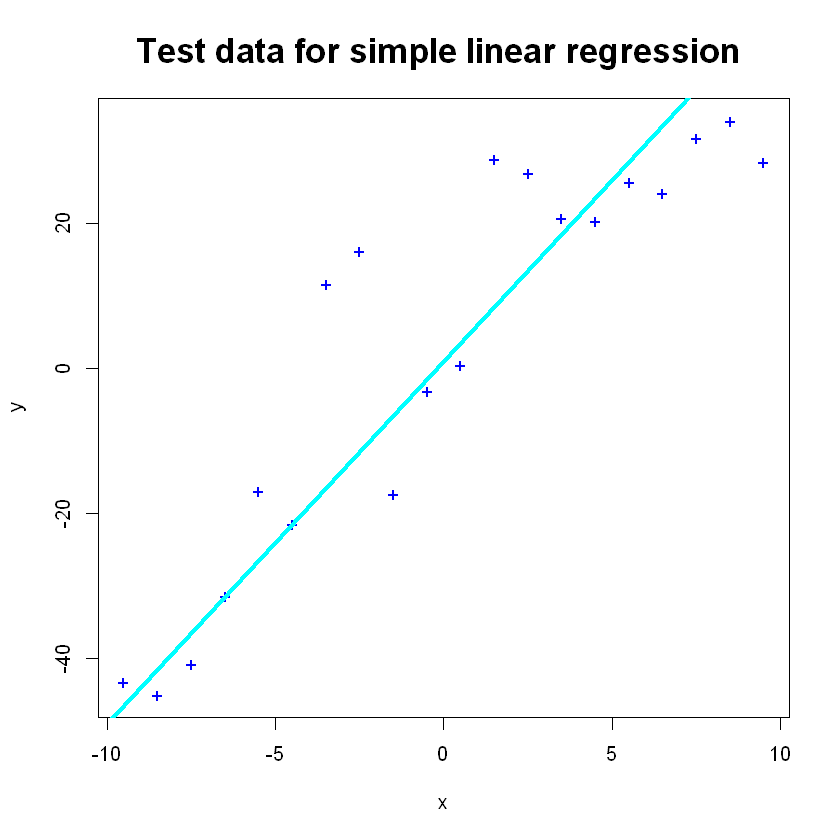

In [3]:
# Plot data points plus the line used in the generation
# Note this line is NOT a regression line, which will be computed below
# It is just an auxiliary line, used to generate the dataset
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=0.9,col="blue",main="Test data for simple linear regression ",cex.main=1.7)
abline(trueA,trueB,lwd=3.5,col="cyan")

## Fit a (classical) least squares linear regression model

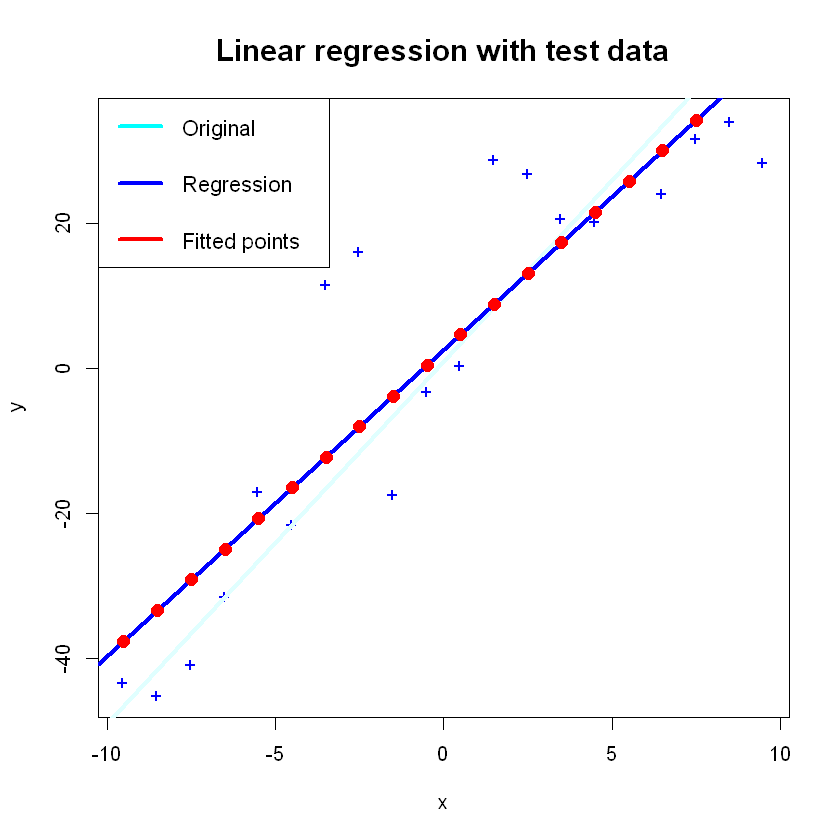

In [4]:
lm.1<-lm(y~x)
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=1.1,col="blue",main="Linear regression with test data",cex.main=1.5)
yhat<-fitted.values(lm.1)
abline(trueA,trueB,lwd=3.5,col="LightCyan")
abline(lm.1,lwd=3.5,col="blue")
points(x,yhat,pch=16,col="red",cex=1.4)
legend("topleft",c("Original    ","","Regression   ","","Fitted points"), lwd=3.5,
       col=c("cyan","white","blue","white","red"),cex=1.1)

### Extract information from the fitted model

In [5]:
print(lm.1)


Call:
lm(formula = y ~ x)

Coefficients:
(Intercept)            x  
      2.507        4.222  



In [6]:
S<-summary(lm.1)
S


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.140  -5.951  -3.854   3.507  24.248 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.5066     2.6939   0.930    0.364    
x             4.2224     0.4672   9.038 4.13e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.05 on 18 degrees of freedom
Multiple R-squared:  0.8194,	Adjusted R-squared:  0.8094 
F-statistic: 81.69 on 1 and 18 DF,  p-value: 4.135e-08


### Regression coefficients

In [7]:
Coeff<-coefficients(lm.1)
a.hat<-Coeff[1]
b.hat<-Coeff[2]
round(a.hat,3)
round(b.hat,3)

(Intercept) 
      2.507

x 
4.222

### Predict the response for a new $ \tilde{x}$

In [8]:
x.tilde<-c(2.5,3)  # just for example
newx<-data.frame(x=x.tilde)

In [9]:
predict(lm.1,newdata=newx)

1        2 
13.06277 15.17400

By default for linear models `type=response`

In [10]:
predict(lm.1,newdata=newx,interval = "confidence")

,fit,lwr,upr
1,13.06277,6.894112,19.23143
2,15.17400,8.794218,21.55377


Confidence intervals for fitted values

$$
    \hat{\mu}=\hat{a}+\hat{b}\cdot\tilde{x}
$$

In [11]:
predict(lm.1,newdata=newx,interval="prediction")

,fit,lwr,upr
1,13.06277,-12.98873,39.11427
2,15.17400,-10.92830,41.27629


Confidence intervals for predicted values, including the $\normaldist(0,\sigma^{2})$ fluctuation around $\hat{y}$.    
(so the results are wider intervals)

# 02. Simple linear regression: Bayesian model

The purpose of fitting a model in this case is to explore the relationship between $y $ and $x $. Since both $y$ and $x$ are continuous, a simple regression line is a good start.

Each observed response ($ y_{i}$) is assumed to be drawn from a normal distribution with mean ($\mu_{i}$) and standard deviation ($\sigma$). 

The expected values ($\mu_{i}$) are themselves determined by the linear predictor ($\beta_{0}+\beta\cdot x_{i}$). In this case, $\beta_{0}$ represents the $y$-intercept (value of $y$ when $x$ is equal to zero) and $\beta$ represents the rate of change in $y$ for every unit change in $x$ (the effect).

We will employ weakly informative _("non informative")_ priors. This choice is always a bit of a balancing act. If the priors are too vague (wide) the MCMC sampler can wander off into nonsense areas of likelihood rather than concentrate around areas of highest likelihood (desired when wanting the outcomes to be largely driven by the data). On the other hand, if the priors are too strong, they may have an influence on the parameters. In such a simple model, this balance is very forgiving - it is for more complex models that prior choice becomes more important.

For this simple model, we will go with Gaussian (normal) priors with relatively large standard deviations (100) for both the intercept and the treatment effect and a wide uniform for the standard deviation. 
The intercept $\beta_{0}$  will be centered either at $\hat{a}$ (`a.hat`), the least squares intercept or at zero, and the slope will be zero centered. Alternatively we could center $x$ and $y$ beforehand and then use a zero-centered prior for  $\beta_{0}$ too.

The model, likelihood $+ $ priors, is:

$$
\begin{array}{lcllcl}
    y_{i}     &\sim &\normaldist(\mu_{i},\sigma^2),\\[0.2cm]
    \mu_{i}   &=    &\beta_{0}+\beta\cdot x_{i},\\[0.2cm]
    \beta_{0} &\sim &\normaldist(\,\hat{a}\,,100^2), \mskip40mu\text{or }\mskip40mu\beta_{0} &\sim &\normaldist(\,0\,,100^2),\\[0.2cm]
    \beta     &\sim &\normaldist(0,100^2),\\[0.2cm]
    \sigma    &\sim &\unifdist(0,100).
\end{array}
$$

Alternative priors for the regression coefficients are $\cauchydist (0,\,\cdot\,)$ distributions, as sugggested by Gelman et al (2008).

Andrew Gelman, Aleks Jakulin, Maria Grazia Pittau, Yu-Sung Su (2008), [A weakly informative default prior distribution for logistic and other regression models, Ann. Appl. Stat. 2(4): 1360-1383.](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full)

There the authors suggest $\cauchydist (0,s)$, with a scale parameter $s=2.5$.

## _brms_ implementation

In [12]:
#install.packages("brms", repos= "https://cloud.r-project.org")
require(brms,quietly=TRUE)

Warning message:
"package 'brms' was built under R version 4.2.3"
Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar




In [13]:
options(mc.cores = parallel::detectCores())

<h6> Depending on your hardware</h6>

In [14]:
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

In [15]:
simple.regression.pred.brms<-brm(y ~ x, data = data.frame(x,y), 
    iter = 8000, warmup = 500, chains = 3, thin = 2,  
    prior = c(prior(normal(0, 100), class = "Intercept"), 
              prior(normal(0, 100), class = "b"), 
              prior(cauchy(0, 5), class = "sigma")
              )
    )

Compiling Stan program...

Start sampling



In [16]:
summary(simple.regression.pred.brms)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ x 
   Data: data.frame(x, y) (Number of observations: 20) 
  Draws: 3 chains, each with iter = 8000; warmup = 500; thin = 2;
         total post-warmup draws = 11250

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.49      2.79    -3.14     7.96 1.00    10009     9552
x             4.22      0.49     3.26     5.21 1.00    10603     9427

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    12.34      2.16     8.95    17.26 1.00     9693     9143

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [17]:
# Choose a new x within the interval of x values
x_tilde<-1

In [18]:
y_tilde<-predict(simple.regression.pred.brms, newdata=data.frame(x=x_tilde))

In [19]:
print(y_tilde)

     Estimate Est.Error      Q2.5    Q97.5
[1,] 6.528798   12.5877 -18.00693 31.69214


#### Compare to the least squares solution

In [20]:
coefficients(S)
sigma(lm.1)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2.506649,2.6938789,0.9304981,3.644257e-01
x,4.222449,0.4671779,9.0382039,4.134917e-08


[1] 12.04739

These values should be compared to the MAP estimators obtained from the Bayesian samples.

##### Prediction for new observations $x=\widetilde{x}$ in the classical framework: Confidence interval

In [21]:
mu.tilde<-as.numeric(a.hat+b.hat*x_tilde)
round(mu.tilde,5)

[1] 6.7291

From the (clasical-frequentist) perspective, the predicted $\tilde{y}$ corresponding to a new $\widetilde{x}$ is given as:

$$
    \widetilde{y}=\tilde{\mu}+\varepsilon,
    \mskip30mu\text{where}\mskip20mu \tilde{\mu}=\hat{a}+\hat{b}\cdot \widetilde{x},
    \mskip30mu \varepsilon\sim\normaldist(0,\sigma),
    \mskip30mu\text{and}\mskip20mu \tilde{\mu},\varepsilon 
    \mskip20mu\text{are independent.}
$$

We can compute the variance of $\tilde{\mu}$ from the covariance matrix $V=\Var{\hat{\beta}}$ of the regression coefficients vector $\hat{\beta}=(\hat{a},\hat{b})'$.

$$
    \tilde{\mu}=\hat{a}+\hat{b}\cdot\widetilde{x}= (1,\widetilde{x})\cdot\hat{\beta}.
    \mskip20mu\text{hence}\mskip10mu \var(\tilde{\mu}) =
    (1,\widetilde{x})\cdot V \cdot(1,\widetilde{x})'
$$

In [22]:
#install.packages("bayesplot",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot,quietly=TRUE)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: 'bayesplot'


The following object is masked from 'package:brms':

    rhat




## Diagnostic plots

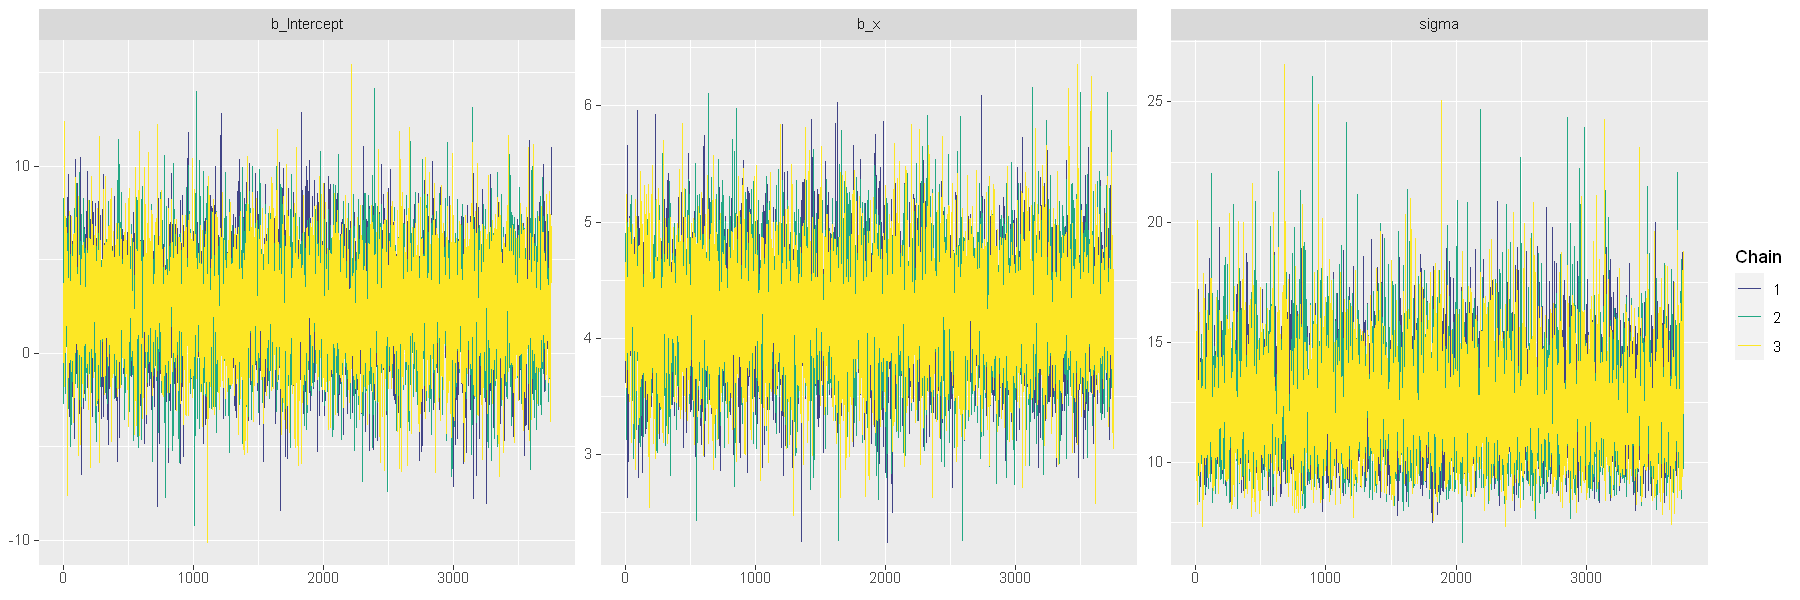

In [23]:
color_scheme_set("viridis")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_trace(simple.regression.pred.brms, pars = c("b_Intercept","b_x","sigma"))

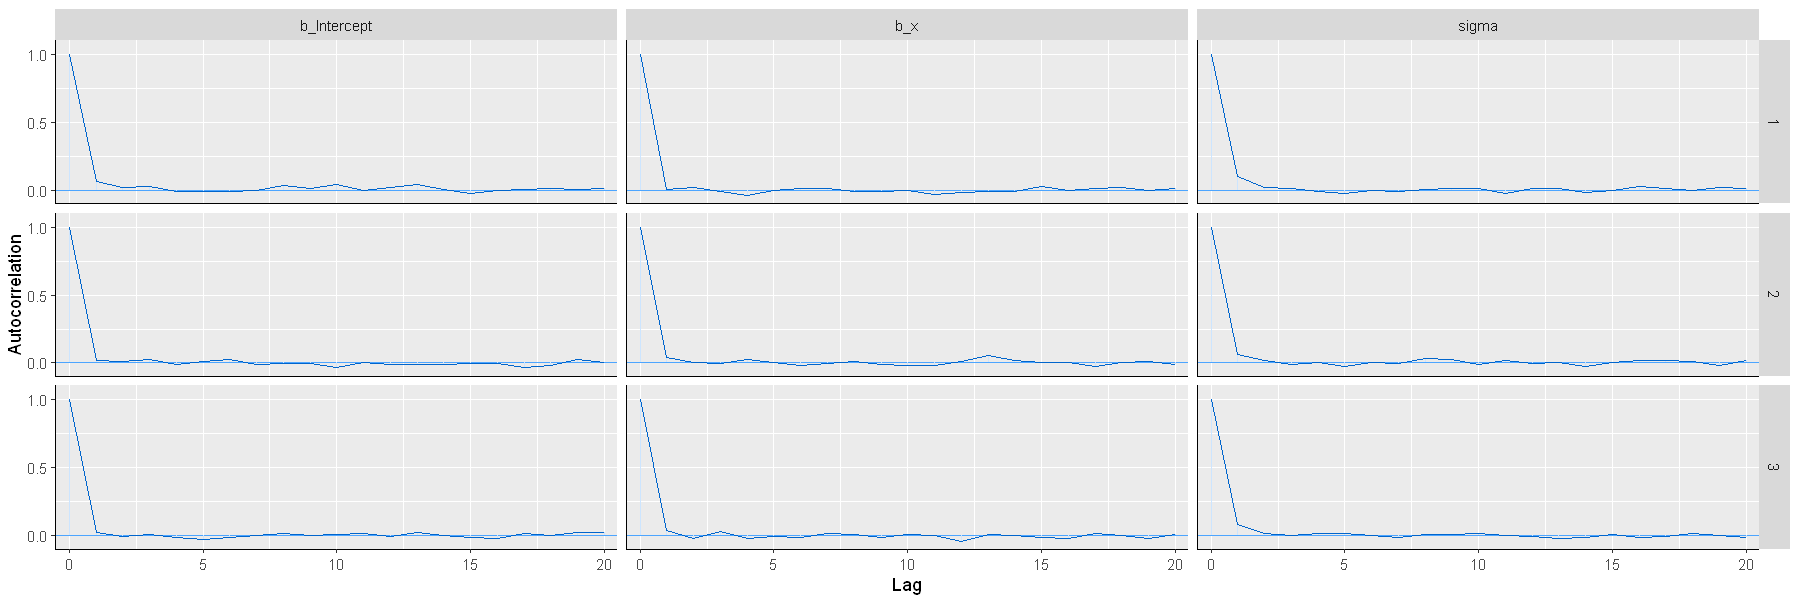

In [24]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_acf(simple.regression.pred.brms, pars = c("b_Intercept","b_x","sigma"))

## Summary plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


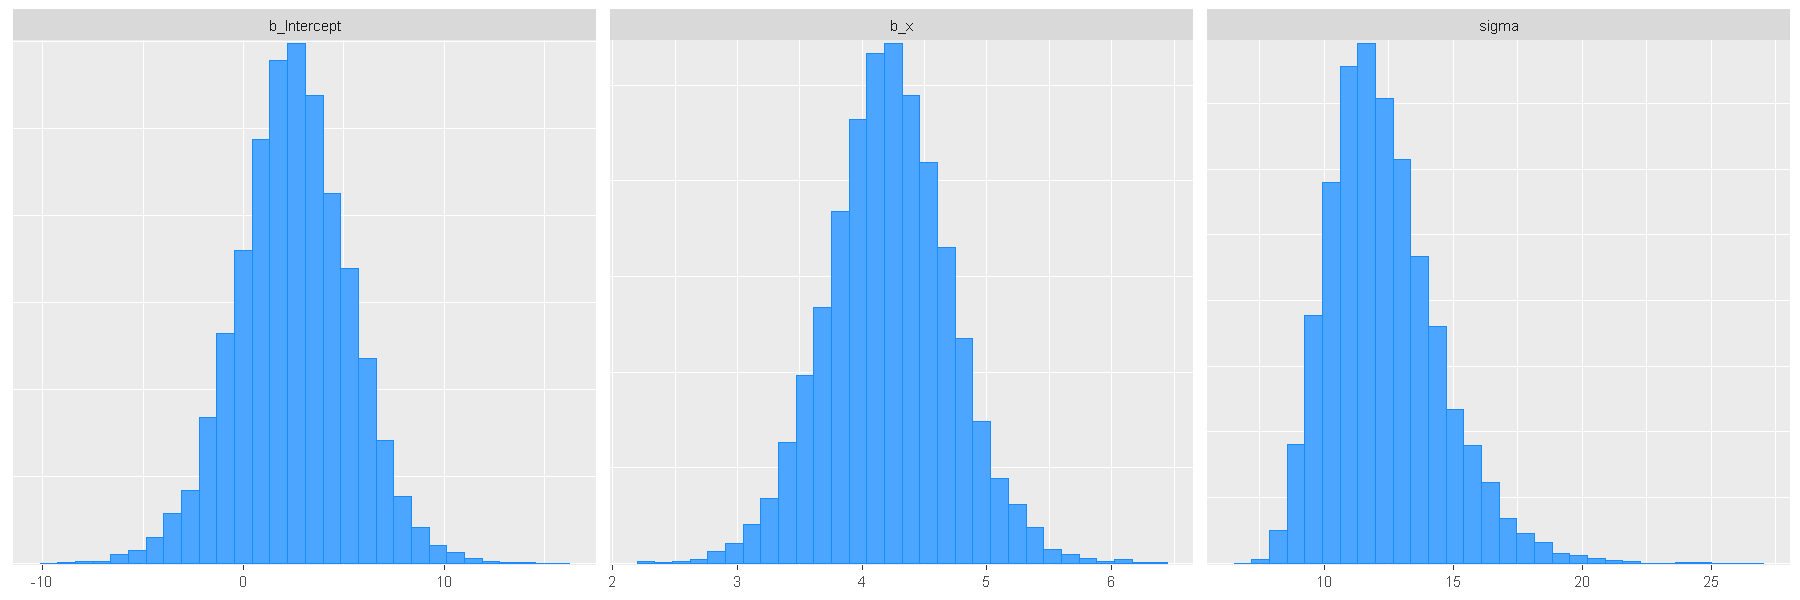

In [25]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_hist(simple.regression.pred.brms,pars=c("b_Intercept","b_x","sigma"))

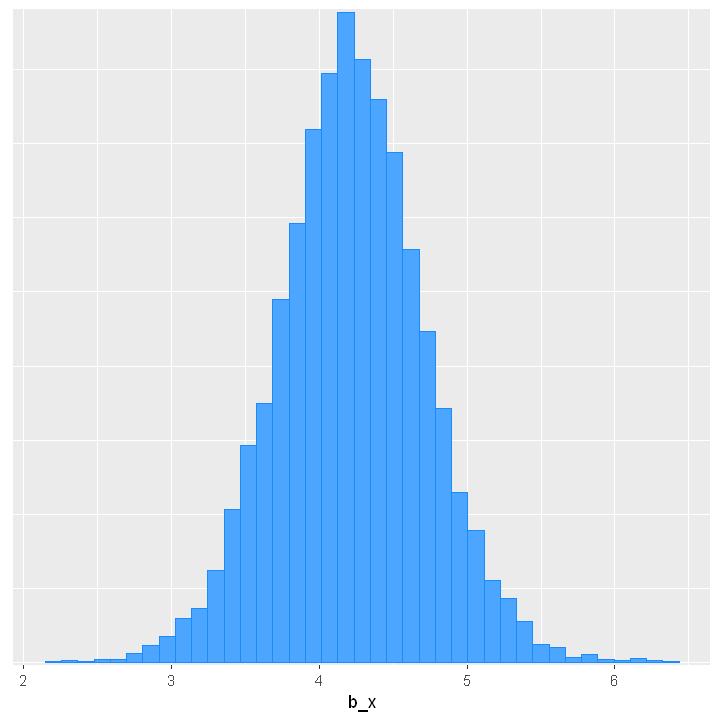

In [26]:
color_scheme_set("brightblue")
options(repr.plot.width=6, repr.plot.height=6)
mcmc_hist(simple.regression.pred.brms,pars=c("b_x"),binwidth=0.11)

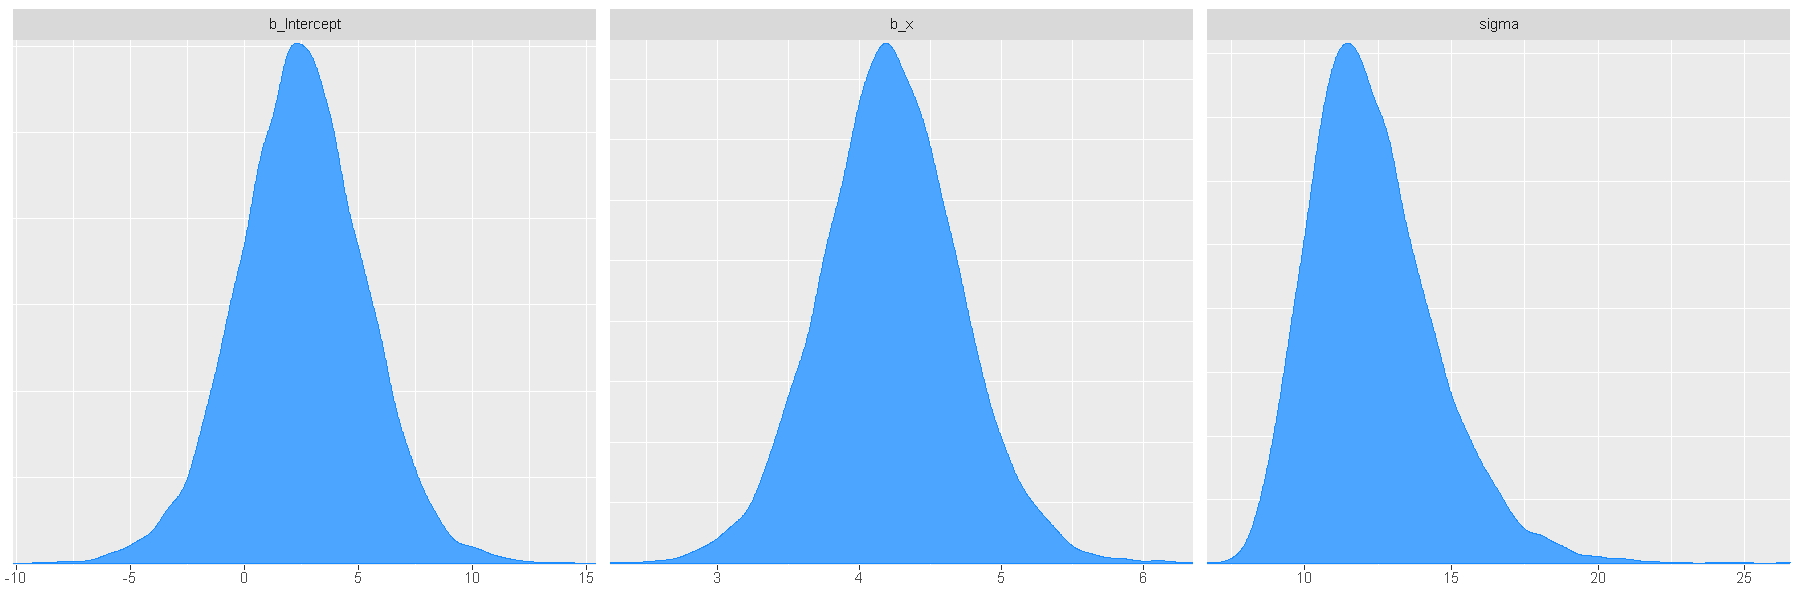

In [27]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_dens(simple.regression.pred.brms,pars=c("b_Intercept","b_x","sigma"))

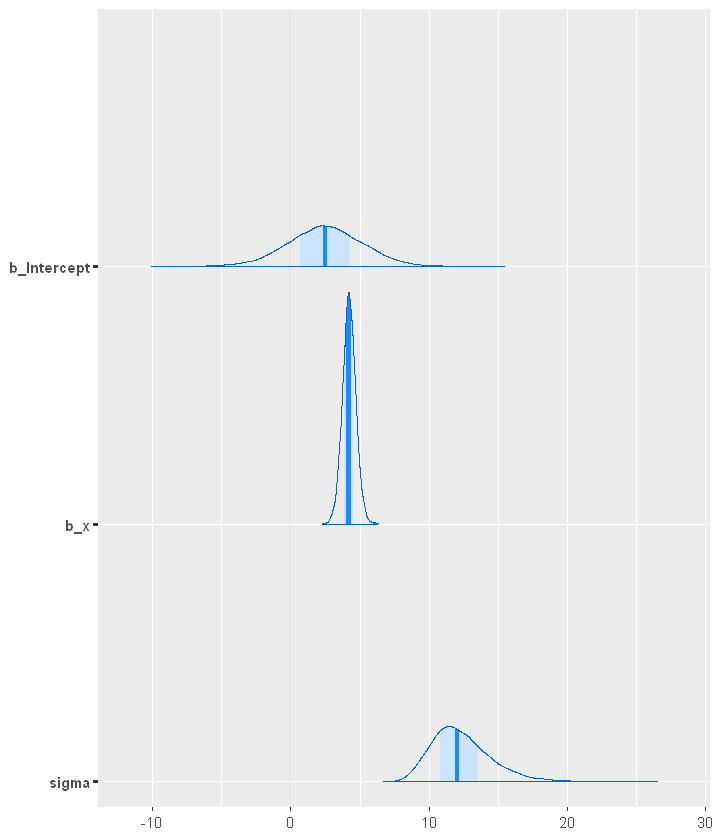

In [28]:
color_scheme_set("brightblue")
options(repr.plot.width=6, repr.plot.height=7)
mcmc_areas(simple.regression.pred.brms,pars=c("b_Intercept","b_x","sigma"))

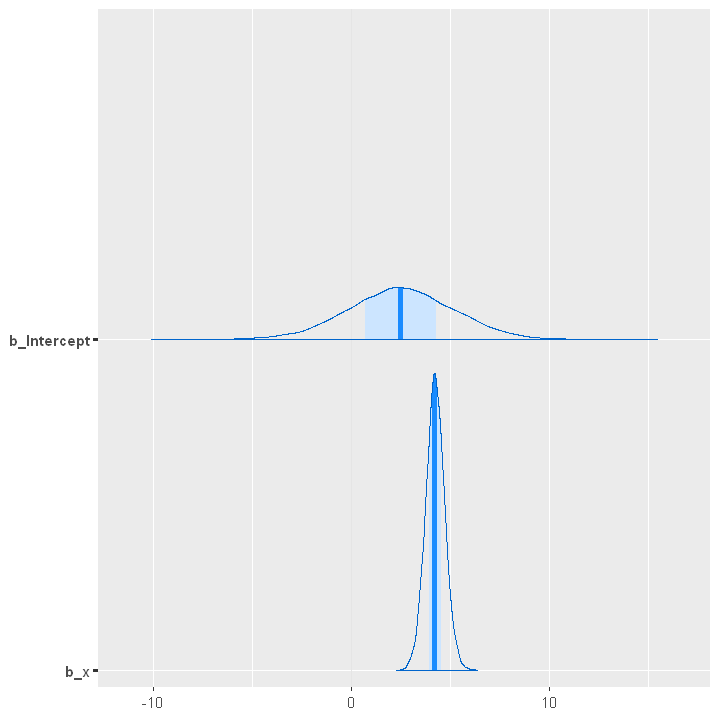

In [29]:
color_scheme_set("brightblue")
options(repr.plot.width=6, repr.plot.height=6)
mcmc_areas(simple.regression.pred.brms,pars=c("b_Intercept","b_x"))

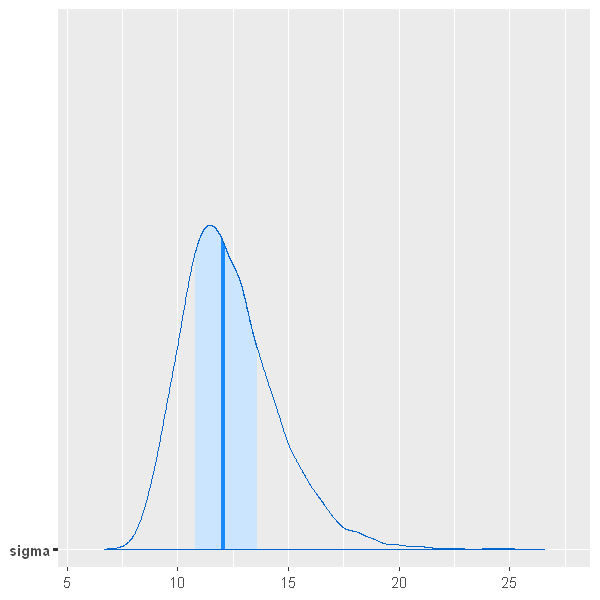

In [30]:
color_scheme_set("brightblue")
options(repr.plot.width=5, repr.plot.height=5)
mcmc_areas(simple.regression.pred.brms,pars=c("sigma"))

# 03. The `Advertising` dataset

From [An Introduction to Statistical Learning with Applications in R (ISLR)](https://www.statlearning.com/). 

File [`Advertising.csv`](https://www.statlearning.com/s/Advertising.csv) from the textbook web page. 

In this section we follow the treatment of the `Advertising` dataset from chapters 2 and 3.

Suppose that we are statistical consultants hired by a client to investigate  the  association  between 
advertising  and  sales  of  a  particular product.  The  `Advertising`  data  set  consists  of  the  
sales  of  that  product in 200 different markets, along with advertising budgets for the product in each 
of those markets for three different media: TV, radio, and newspaper.  It  is  not  possible  for  our  
client  to directly increase sales of the product. On the other hand, they can control the advertising
expenditure  in  each  of  the  three  media.  Therefore,  if  we determine that there 
is an association between advertising and sales, then we can instruct our client to adjust 
advertising budgets, thereby indirectly increasing sales.

In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.
In this setting, the advertising budgets are  input  variables  while sales is an output  variable. 
The input variables are typically denoted using the symbol $X$, with a subscript to distinguish them. So $ X_{1}$ might be the TV budget, 
$X_{2}$ the radio  budget, and $X_{3}$ the newspaper  budget. The inputs go by different names, such as _predictors,_
_independent variables,_ _features,_ or sometimes just _variables._ The output variable —in this case, sales— is often 
called the _response_  or _dependent  variable,_ and is typically denoted using the symbol $Y$.

### Read dataset.

Omit first column, the index of each sample. If needed it could be recovered by: `row.names(Advertising)`.

In [31]:
Advertising<-read.csv("Data/Advertising.csv")
#Advertising<-read.csv("https://www.statlearning.com/s/Advertising.csv")
Advertising<-Advertising[,-1]

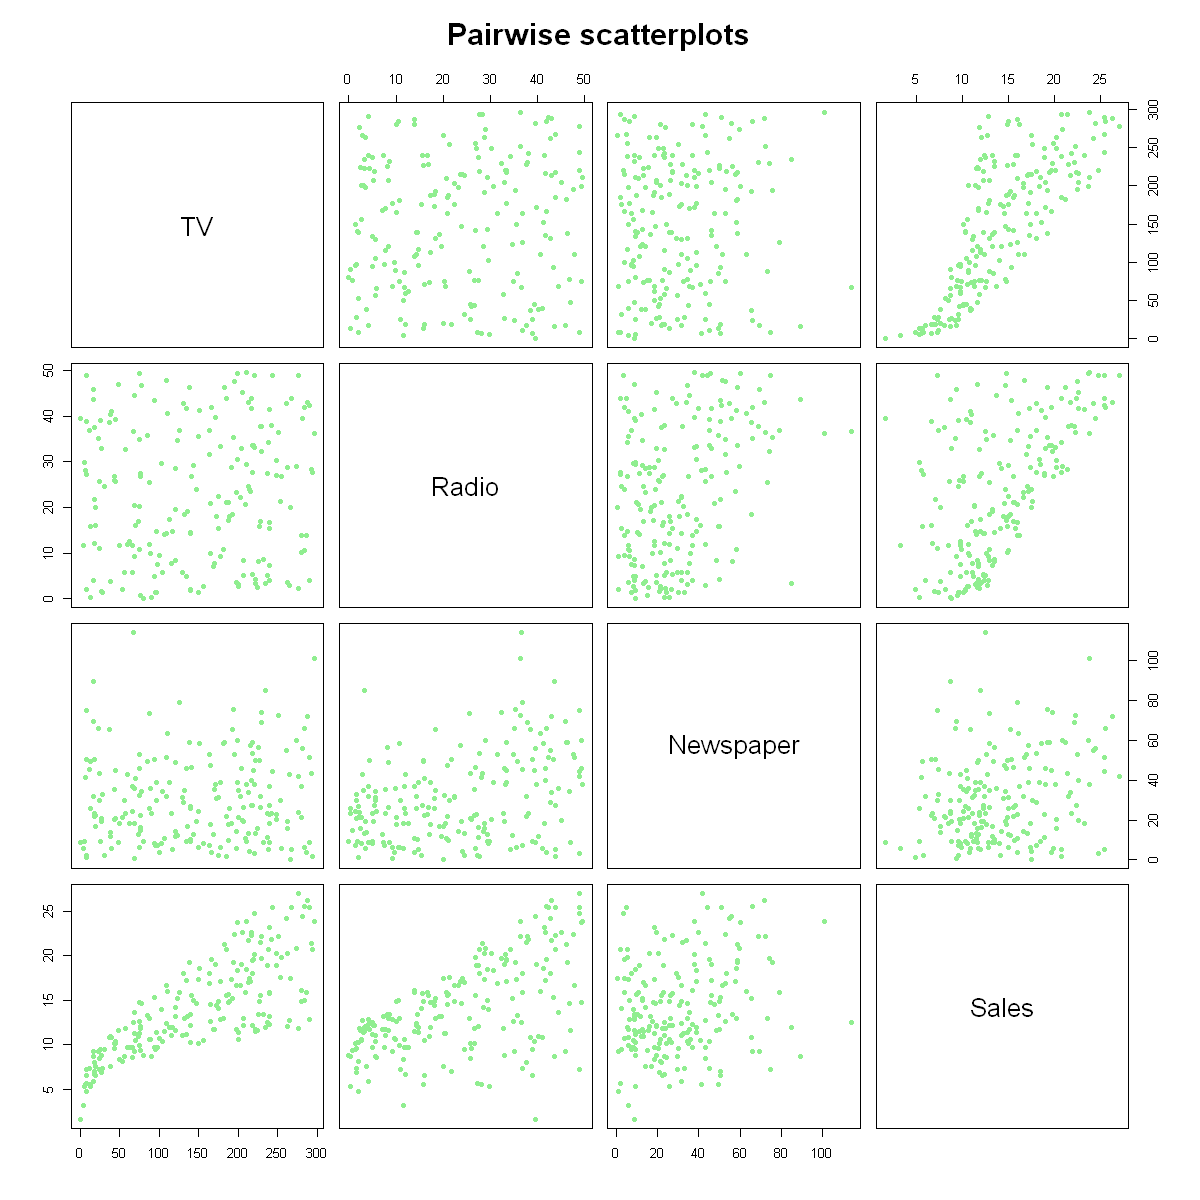

In [32]:
options(repr.plot.width=10, repr.plot.height=10)
plot(Advertising,pch=19,col="LightGreen",cex=0.8,main="Pairwise scatterplots",cex.main=1.5)

In [33]:
#cor(Advertising)
#round(cor(Advertising),2)
round(cor(Advertising),1)

,TV,Radio,Newspaper,Sales
TV,1.0,0.1,0.1,0.8
Radio,0.1,1.0,0.4,0.6
Newspaper,0.1,0.4,1.0,0.2
Sales,0.8,0.6,0.2,1.0


## Multiple regression (classical)

Multiple linear regression of Sales on all three predictors

In [34]:
lm.Advertising.01<-lm(Sales~TV+Radio+Newspaper,data=Advertising)
# Equivalent, alternative notation
#lm.Advertising.01<-lm(Sales~.,data=Advertising)
S<-summary(lm.Advertising.01)
S


Call:
lm(formula = Sales ~ TV + Radio + Newspaper, data = Advertising)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
Radio        0.188530   0.008611  21.893   <2e-16 ***
Newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


In [35]:
lm.Advertising.02<-lm(Sales~(TV+Radio+Newspaper)^2,data=Advertising)
S2<-summary(lm.Advertising.02)
S2


Call:
lm(formula = Sales ~ (TV + Radio + Newspaper)^2, data = Advertising)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9239 -0.3954  0.1873  0.5976  1.5267 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.460e+00  3.176e-01  20.342   <2e-16 ***
TV               2.033e-02  1.609e-03  12.633   <2e-16 ***
Radio            2.293e-02  1.141e-02   2.009   0.0460 *  
Newspaper        1.703e-02  1.007e-02   1.691   0.0924 .  
TV:Radio         1.139e-03  5.716e-05  19.930   <2e-16 ***
TV:Newspaper    -7.971e-05  3.579e-05  -2.227   0.0271 *  
Radio:Newspaper -1.096e-04  2.363e-04  -0.464   0.6433    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9383 on 193 degrees of freedom
Multiple R-squared:  0.9686,	Adjusted R-squared:  0.9677 
F-statistic: 993.3 on 6 and 193 DF,  p-value: < 2.2e-16


In [36]:
A<-anova(lm.Advertising.01)
A

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TV,1,3.314618e+03,3.314618e+03,1.166731e+03,1.809337e-84
Radio,1,1.545617e+03,1.545617e+03,5.440501e+02,1.882722e-58
Newspaper,1,8.871717e-02,8.871717e-02,3.122805e-02,8.599151e-01
Residuals,196,5.568253e+02,2.840945e+00,NA,NA


In [37]:
A2<-anova(lm.Advertising.02)
A2

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TV,1,3.314618e+03,3.314618e+03,3764.6174956,1.490247e-128
Radio,1,1.545617e+03,1.545617e+03,1755.4526683,7.624537e-99
Newspaper,1,8.871717e-02,8.871717e-02,0.1007616,7.512607e-01
TV:Radio,1,3.825136e+02,3.825136e+02,434.4443924,2.677349e-51
TV:Newspaper,1,4.192310e+00,4.192310e+00,4.7614660,3.031156e-02
Radio:Newspaper,1,1.894225e-01,1.894225e-01,0.2151388,6.432918e-01
Residuals,193,1.699300e+02,8.804661e-01,NA,NA


Rename response and model for the sake of pithy expressions

In [38]:
y<-Advertising$Sales
n<-length(y)
n
# (number of predictors)
p1<-3 
# (number of columns in the regression matrix, including the colummn of ones for the intercept)
m<-p1+1
p1
n

[1] 200

[1] 3

[1] 200

In [39]:
lm.1<-lm.Advertising.01
lm.2<-lm.Advertising.02

In [40]:
# Keep the classical intercept (eventually to center the Bayesian prior for the intercept parameter)
beta1<-as.numeric(coef(lm.1))
beta1.0.hat<-beta1[1]
round(beta1.0.hat,4)
beta2<-as.numeric(coef(lm.2))
beta2.0.hat<-beta2[1]
round(beta2.0.hat,4)

[1] 2.9389

[1] 6.4602

In [41]:
X1<-model.matrix(lm.1)
attr(X1,"assign")<-NULL
# Remove the "intercept" column of ones 
X1<-X1[,-1]
#str(X1)
head(X1)
X2<-model.matrix(lm.2)
attr(X2,"assign")<-NULL
# Number of columns in X2
p2<-ncol(X2)
p2
# Remove the "intercept" column of ones 
X2<-X2[,-1]
#str(X2)
head(X2)

,TV,Radio,Newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4
6,8.7,48.9,75.0


[1] 7

,TV,Radio,Newspaper,TV:Radio,TV:Newspaper,Radio:Newspaper
1,230.1,37.8,69.2,8697.78,15922.92,2615.76
2,44.5,39.3,45.1,1748.85,2006.95,1772.43
3,17.2,45.9,69.3,789.48,1191.96,3180.87
4,151.5,41.3,58.5,6256.95,8862.75,2416.05
5,180.8,10.8,58.4,1952.64,10558.72,630.72
6,8.7,48.9,75.0,425.43,652.50,3667.50


In [42]:
round(sigma(lm.1),4)
round(sigma(lm.2),4)

[1] 1.6855

[1] 0.9383

## 04. Bayesian linear regression

## Model

### Likelihood

Each of the $n$ observed responses $y_{i}$ ($1\leq i\leq n$) is assumed to be drawn from a normal distribution with mean $\mu_{i}$ and standard deviation $\sigma$ (or precision $\tau=1/\sigma^{2}$).

The expected values ($\mu_{i}$) are themselves determined by the linear predictor ($\beta_{0}+x_{i}\cdot\beta$), $x_{i}\in\mathbb{R}^p$. 

$\beta_{0}$ is the $y$-intercept and each $\beta_{j}\in\R$, $j\geq 1$ represents the rate of change in $y$ for every unit change in the $j$-th effect $x_{j}$ ($1\leq j\leq p$).

### Priors

Gaussian (normal) priors with relatively large standard deviations for the regression coefficients, intercept centered on the classical estimate and the others on zero,
and a uniform for the standard deviation. 

In JAGS the normal distribution is parameterized with mean and precision $\tau=1/\sigma^{2}$, hence a noninformative normal prior will have a _small_ precision. In Stan the normal distribution is parameterrized with $\sigma$, as in R.
  
$$
\begin{array}{lcl}
        y_{i}         &\sim &\normaldist(\mu_{i},\sigma),\\[0.2cm]
        \mu_{i}       &=    &\beta_{0}+x_{i}\cdot\beta,\mskip20mu 1\leq i\leq n.\\[0.2cm]
         y            &\sim &\normaldist(\mu,\sigma), \mskip20mu\text{(vector notation)}\\[0.2cm]  
        \mu           &=    &\beta_{0}+X\cdot\beta, \mskip20mu\text{(matrix notation)}\\[0.2cm]
        \beta_{0}     &\sim &\cauchydist(0,10),\\[0.2cm]
        \beta_{j}     &\sim &\cauchydist(0,2.5),\mskip20mu 1\leq j\leq p.\\[0.2cm]
        \sigma        &\sim &\invgammadist(4,0.02).
\end{array}
$$

Alternative priors for the regression coefficients are $\cauchydist (0,\,\cdot\,)$ distributions, as sugggested by Gelman et al (2008).

Andrew Gelman, Aleks Jakulin, Maria Grazia Pittau, Yu-Sung Su (2008), [A weakly informative default prior distribution for logistic and other regression models, Ann. Appl. Stat. 2(4): 1360-1383.](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full)

There the authors suggest $\cauchydist (0,s)$, with a scale parameter $s=2.5$.

In [43]:
#install.packages("actuar",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(actuar,quietly=TRUE)


Attaching package: 'actuar'


The following objects are masked from 'package:stats':

    sd, var


The following object is masked from 'package:grDevices':

    cm




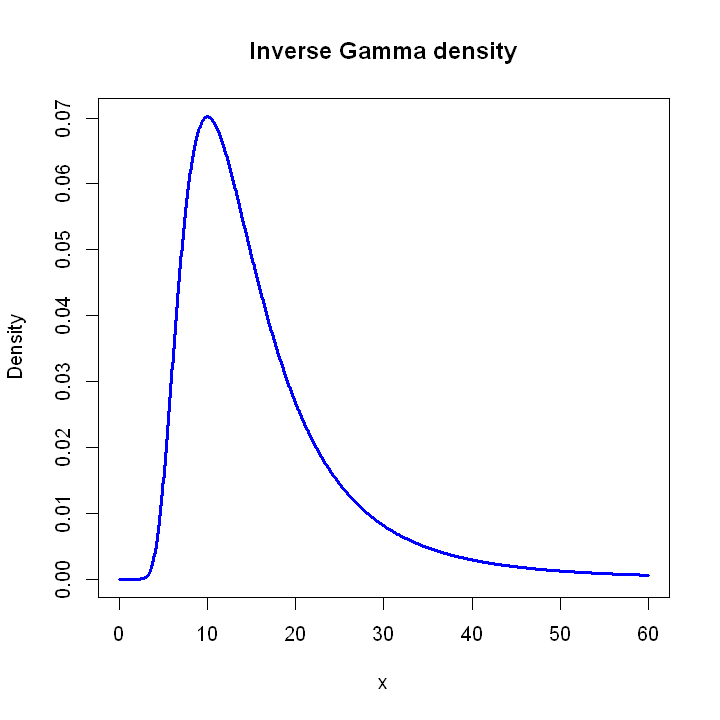

In [44]:
u<-seq(0.0001,60,length=1000)
options(repr.plot.width=6, repr.plot.height=6)
plot(u,dinvgamma(u,shape=4,rate=0.02),"l",lwd=3.0,col="blue",
    main="Inverse Gamma density",xlab="x",ylab="Density")

## _brms_ implementation

In [45]:
#install.packages("brms", repos= "https://cloud.r-project.org")
require(brms,quietly=TRUE)

In [46]:
options(mc.cores = parallel::detectCores())

<h6> Depending on your hardware</h6>

In [47]:
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

In [48]:
Advertising.brms.01<-brm(Sales~TV+Radio+Newspaper,data=Advertising,
    iter = 8000, warmup = 500, chains = 3, thin = 2,  
    prior = c(prior(cauchy(0, 10), class = "Intercept"), 
              prior(cauchy(0, 2.5), class = "b"), 
              prior(inv_gamma(4,0.02), class = "sigma")
              )
    )

Compiling Stan program...

Start sampling



In [49]:
Advertising.brms.02<-brm(Sales~(TV+Radio+Newspaper)^2,data=Advertising,
    iter = 8000, warmup = 500, chains = 3, thin = 2,  
    prior = c(prior(cauchy(0, 10), class = "Intercept"), 
              prior(cauchy(0, 2.5), class = "b"), 
              prior(inv_gamma(4,0.02), class = "sigma")
              )
    )

Compiling Stan program...

Start sampling

Warning message:
"There were 7214 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [50]:
Advertising.brms.02b<-brm(Sales~(TV+Radio+Newspaper)^2,data=Advertising,
    iter = 8000, warmup = 500, chains = 3, thin = 2,  
    prior = c(prior(cauchy(0, 10), class = "Intercept"), 
              prior(cauchy(0, 2.5), class = "b"), 
              prior(inv_gamma(4,0.02), class = "sigma")
              ),
    control=list(max_treedepth=12)
    )

Compiling Stan program...

Start sampling



In [51]:
summary(Advertising.brms.01)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Sales ~ TV + Radio + Newspaper 
   Data: Advertising (Number of observations: 200) 
  Draws: 3 chains, each with iter = 8000; warmup = 500; thin = 2;
         total post-warmup draws = 11250

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.94      0.31     2.33     3.56 1.00    10841     9243
TV            0.05      0.00     0.04     0.05 1.00    10677     9694
Radio         0.19      0.01     0.17     0.21 1.00    10499     9454
Newspaper    -0.00      0.01    -0.01     0.01 1.00    10596    10233

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     1.68      0.09     1.52     1.85 1.00    10844     9153

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergenc

In [52]:
summary(Advertising.brms.02)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Sales ~ (TV + Radio + Newspaper)^2 
   Data: Advertising (Number of observations: 200) 
  Draws: 3 chains, each with iter = 8000; warmup = 500; thin = 2;
         total post-warmup draws = 11250

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           6.46      0.32     5.84     7.08 1.00     8860     9092
TV                  0.02      0.00     0.02     0.02 1.00    10457     9369
Radio               0.02      0.01     0.00     0.04 1.00     8646     9011
Newspaper           0.02      0.01    -0.00     0.04 1.00     9366     9095
TV:Radio            0.00      0.00     0.00     0.00 1.00     9849     9859
TV:Newspaper       -0.00      0.00    -0.00    -0.00 1.00    10598    10375
Radio:Newspaper    -0.00      0.00    -0.00     0.00 1.00     9100     9952

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sig

In [53]:
summary(Advertising.brms.02b)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Sales ~ (TV + Radio + Newspaper)^2 
   Data: Advertising (Number of observations: 200) 
  Draws: 3 chains, each with iter = 8000; warmup = 500; thin = 2;
         total post-warmup draws = 11250

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           6.46      0.31     5.86     7.07 1.00     6425     8250
TV                  0.02      0.00     0.02     0.02 1.00     8347     9004
Radio               0.02      0.01     0.00     0.05 1.00     5385     6360
Newspaper           0.02      0.01    -0.00     0.04 1.00     6953     7064
TV:Radio            0.00      0.00     0.00     0.00 1.00     7334     8922
TV:Newspaper       -0.00      0.00    -0.00    -0.00 1.00     8321     8794
Radio:Newspaper    -0.00      0.00    -0.00     0.00 1.00     7064     8199

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sig

## Diagnostic plots

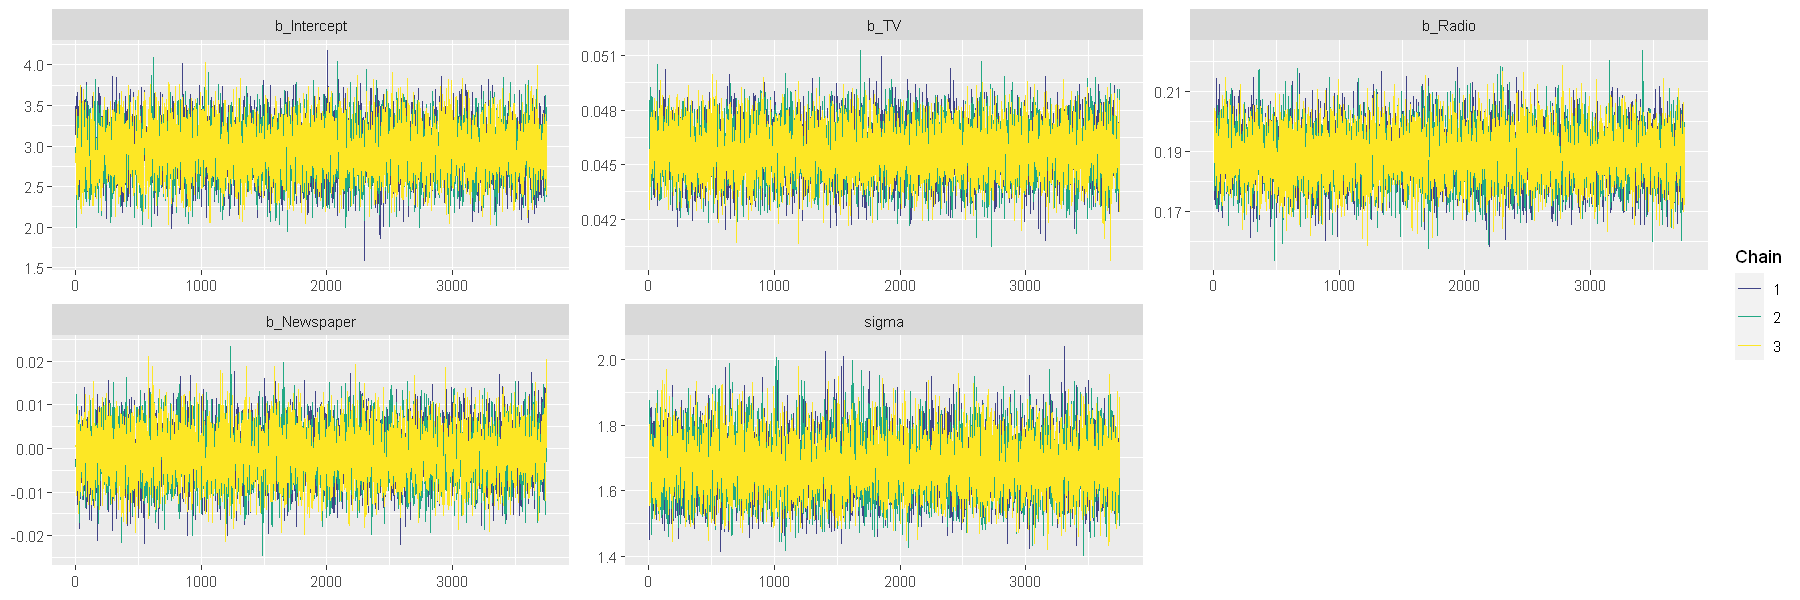

In [54]:
color_scheme_set("viridis")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_trace(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

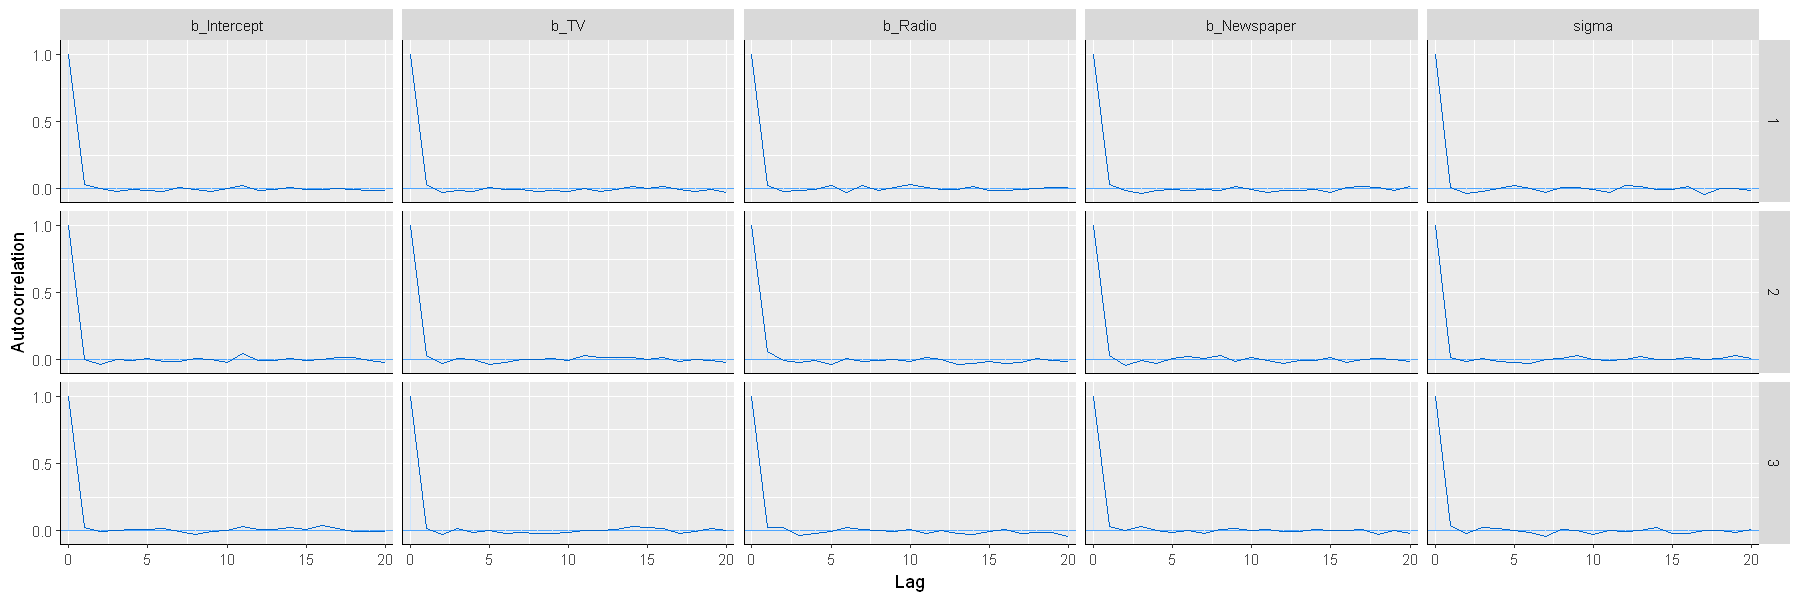

In [55]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_acf(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

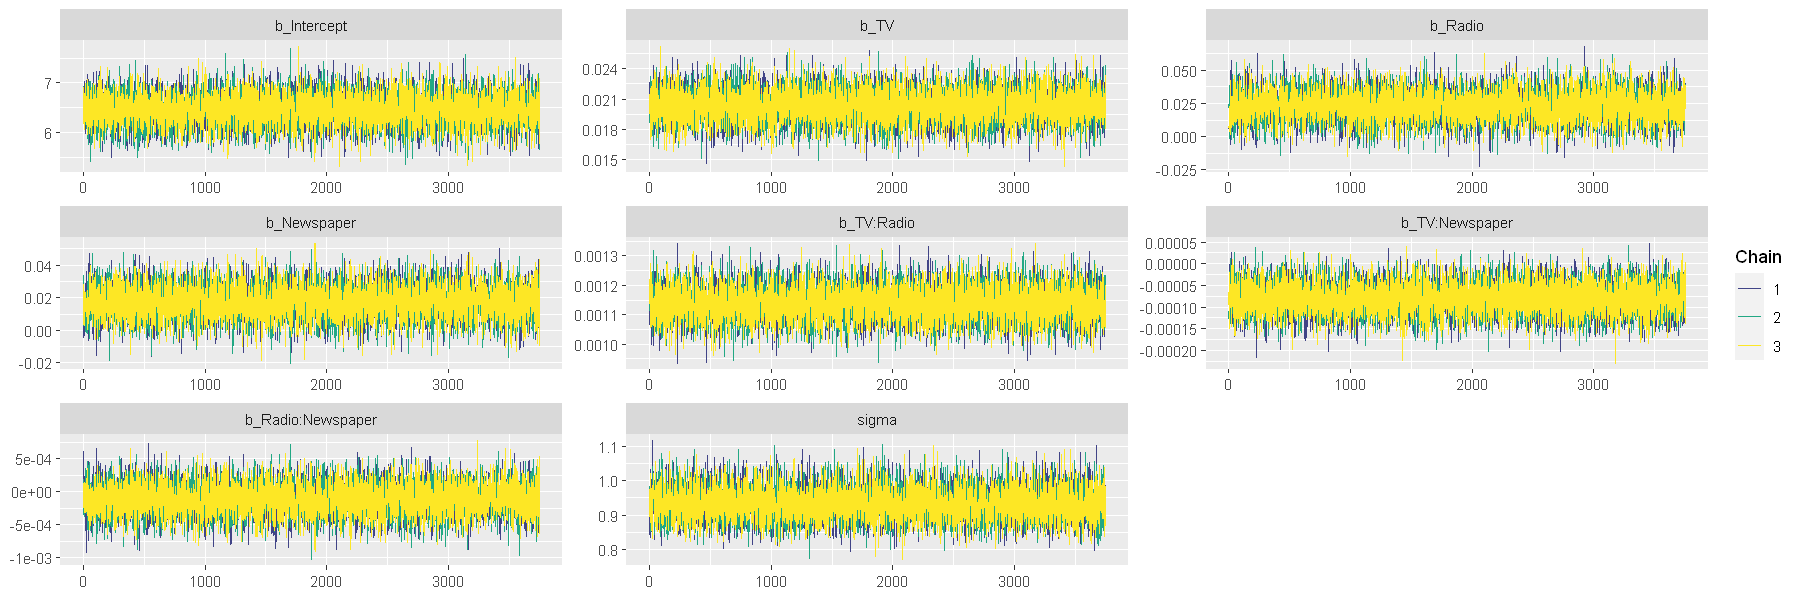

In [56]:
color_scheme_set("viridis")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_trace(Advertising.brms.02,pars=c(vars(starts_with("b"),sigma)))

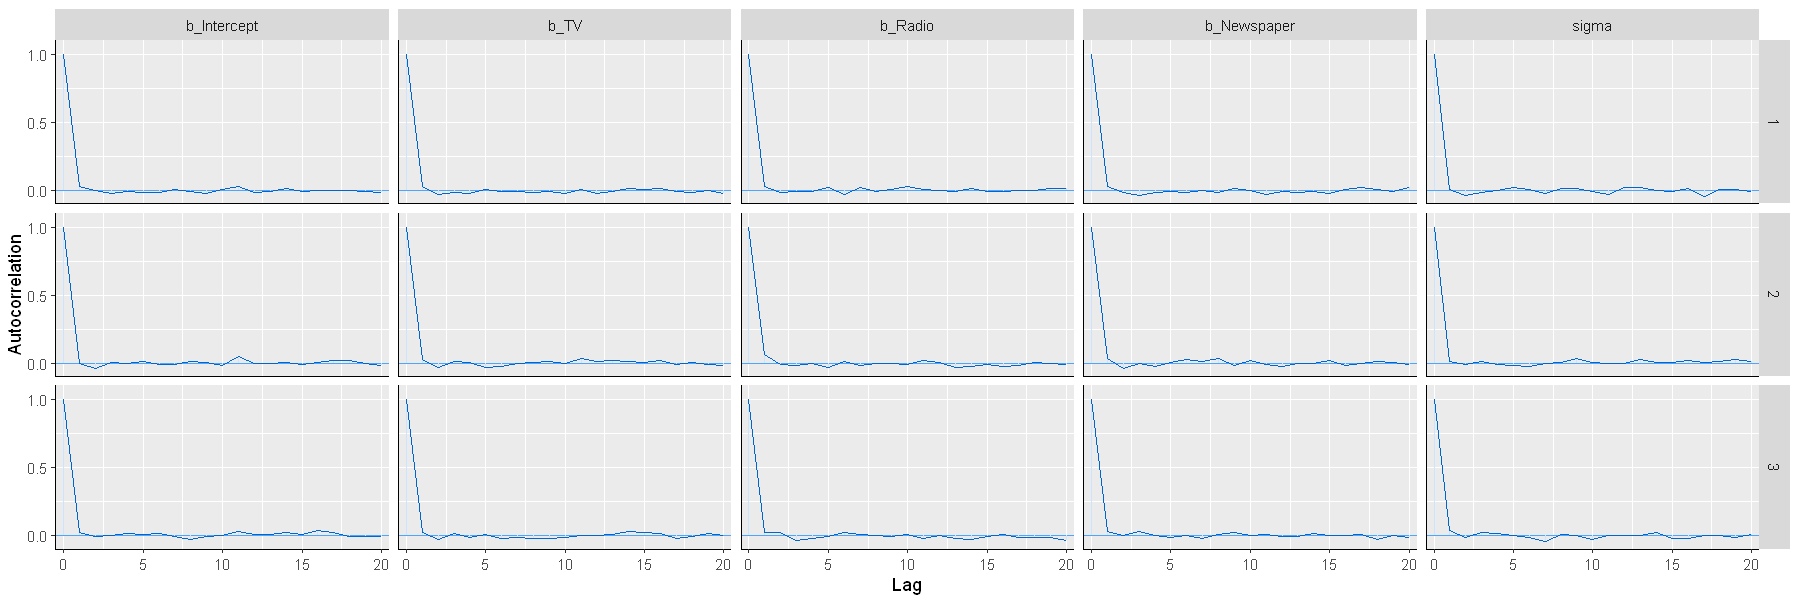

In [57]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_acf(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

## Summary plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


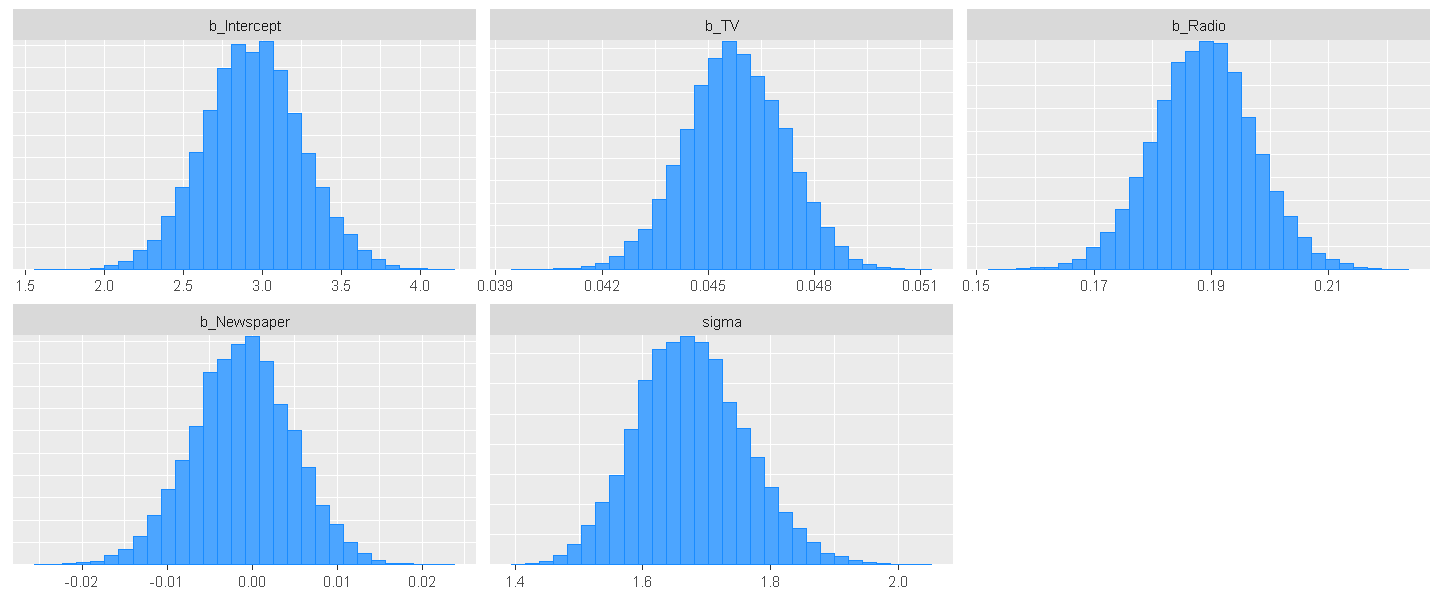

In [58]:
color_scheme_set("brightblue")
options(repr.plot.width=12, repr.plot.height=5)
mcmc_hist(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

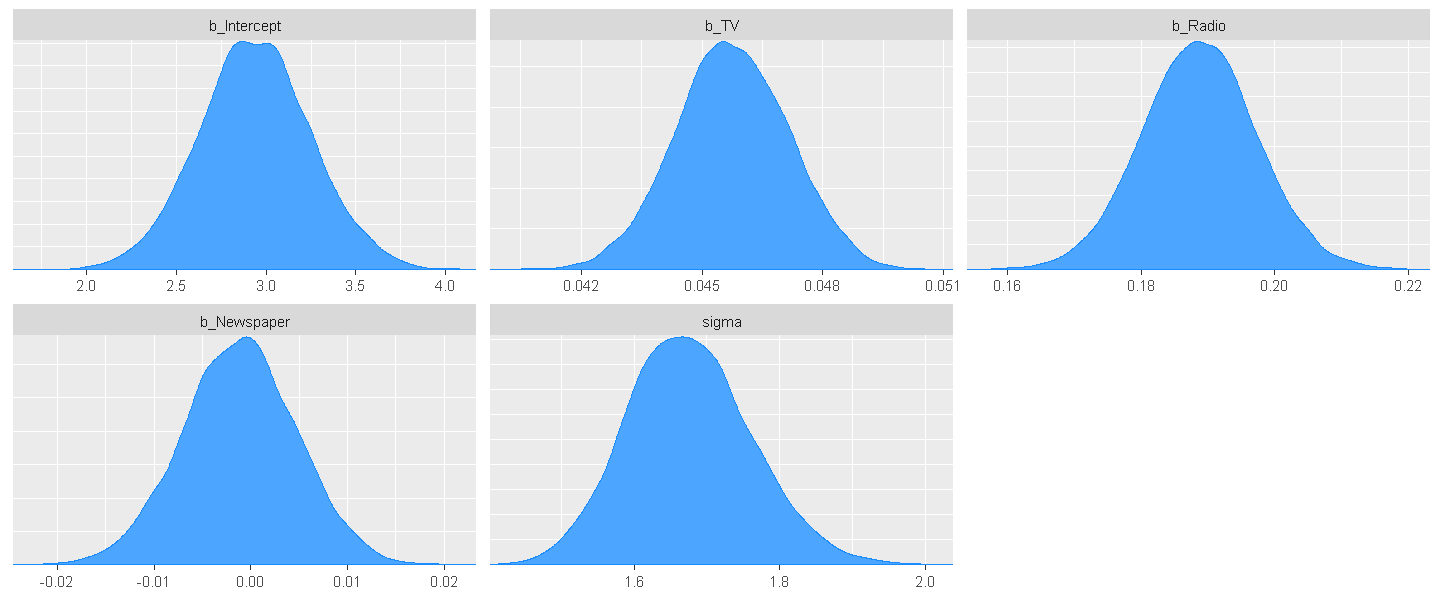

In [59]:
color_scheme_set("brightblue")
options(repr.plot.width=12, repr.plot.height=5)
mcmc_dens(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

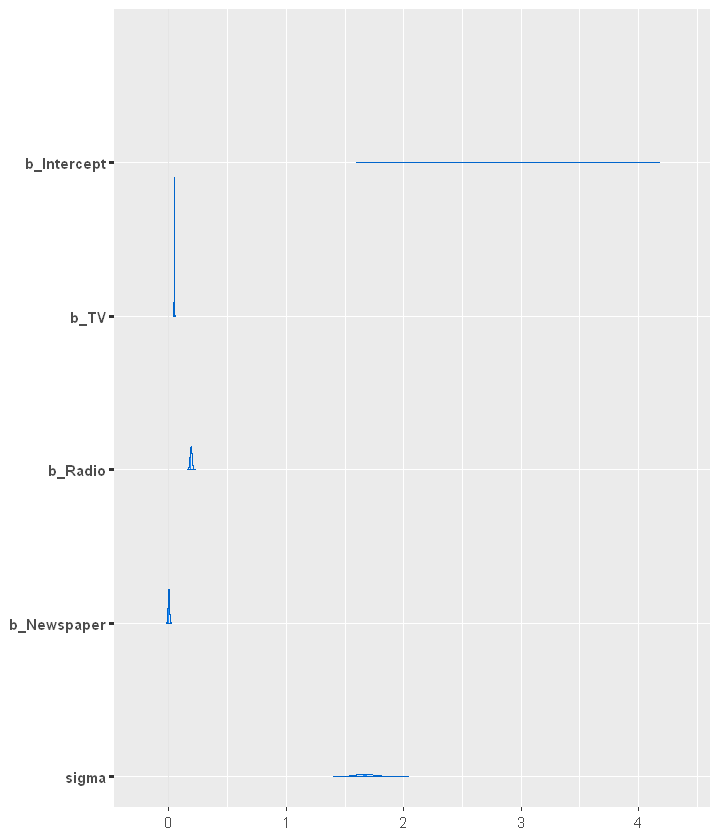

In [60]:
color_scheme_set("brightblue")
options(repr.plot.width=6, repr.plot.height=7)
mcmc_areas(Advertising.brms.01,pars=c(vars(starts_with("b"),sigma)))

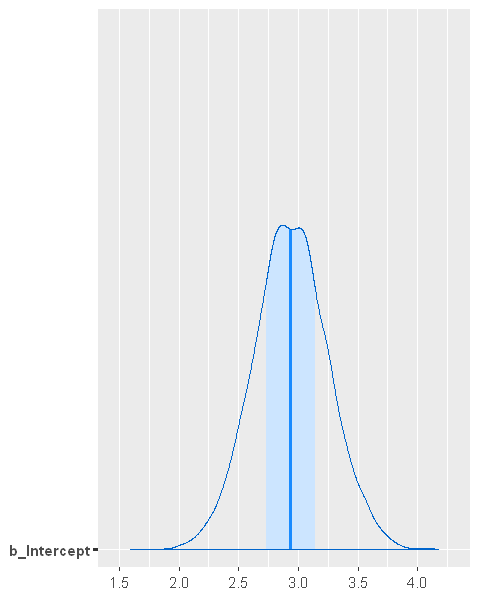

In [61]:
color_scheme_set("brightblue")
options(repr.plot.width=4, repr.plot.height=5)
mcmc_areas(Advertising.brms.01,pars=c("b_Intercept"))

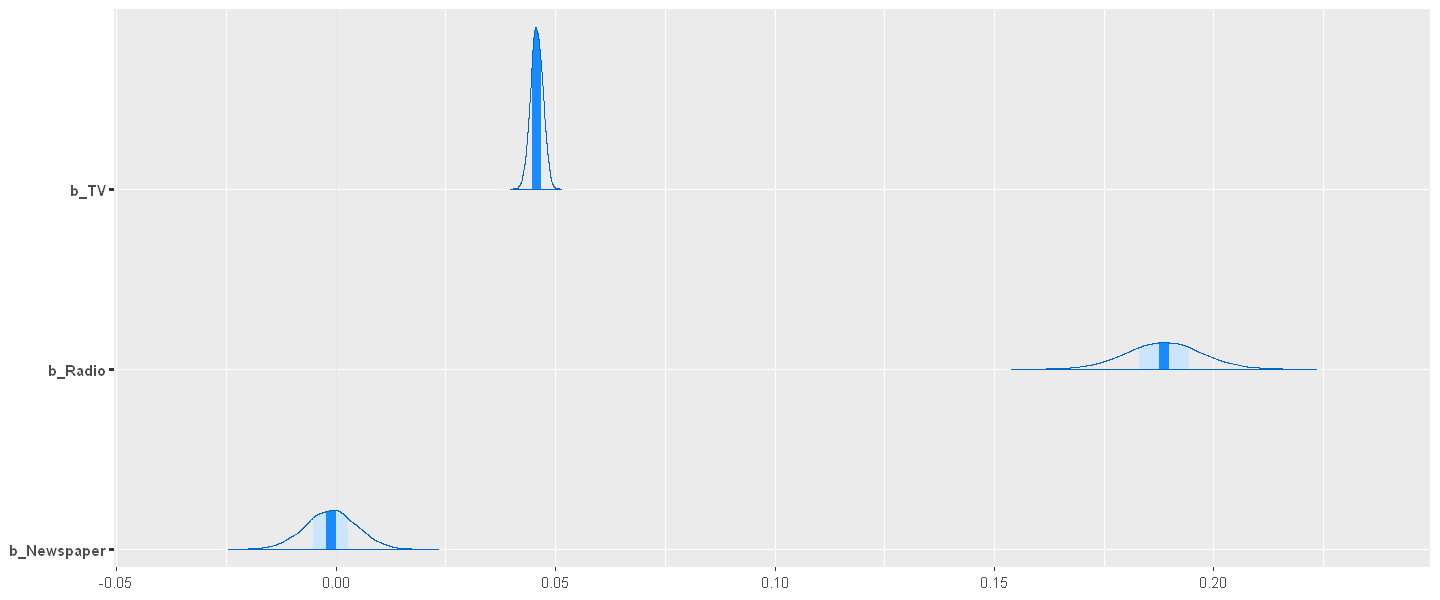

In [62]:
color_scheme_set("brightblue")
options(repr.plot.width=12, repr.plot.height=5)
mcmc_areas(Advertising.brms.01,pars=c("b_TV","b_Radio","b_Newspaper"))

## Predicting the response to new observations

In [63]:
# Just to have an example of a new observation to test prediction
x.tilde1<-colMeans(X1)
round(x.tilde1,2)
x.tilde2<-colMeans(X2)
round(x.tilde2,2)

TV     Radio Newspaper 
   147.04     23.26     30.55

TV           Radio       Newspaper        TV:Radio    TV:Newspaper 
         147.04           23.26           30.55         3490.31         4598.13 
Radio:Newspaper 
         824.73

In [64]:
set.seed(1234)
P1<-predict(Advertising.brms.01,newdata=as.data.frame(t(x.tilde1)))
P1

Estimate,Est.Error,Q2.5,Q97.5
14.03372,1.662761,10.77586,17.29679


##### Compare with prediction from the classical solution

In [65]:
predict(lm.1,newdata=as.data.frame(t(x.tilde1)))

1 
14.0225

In [66]:
set.seed(1234)
P1.sample<-predict(Advertising.brms.01,newdata=as.data.frame(t(x.tilde1)),summary=FALSE)
str(P1.sample)

 num [1:11250, 1] 12.1 14.5 15.9 10.5 14.8 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : NULL


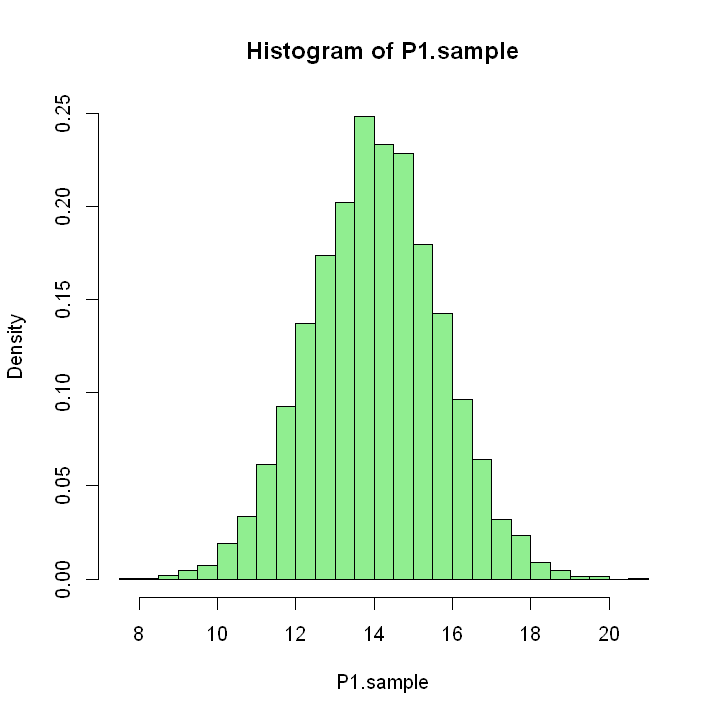

In [67]:
options(repr.plot.width=6, repr.plot.height=6)
hist(P1.sample,col="LightGreen",freq=FALSE,breaks=30)